In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from embcomp.test_cases.confusion import (
    case1,
    case2,
    case3,
    case4,
    case5,
    plot_confusion,
)
from embcomp.test_cases.utils import plot

np.random.seed(42)

### Confusion 1

- Case: 5 equal sized groups, well separated
- Expected: no confusion

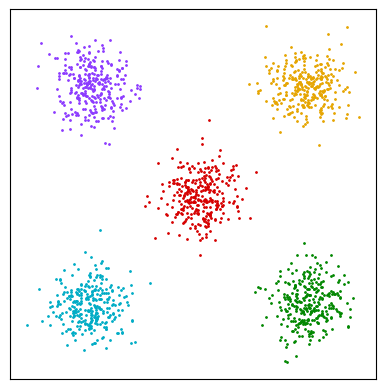

In [3]:
plot(case1())

### Confusion 2

- Case: 5 equal sized groups, 2 mixed
- Expected: confusion with last two groups

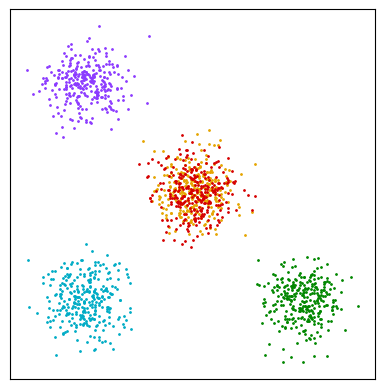

In [4]:
plot(case2())

### Confusion 3

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

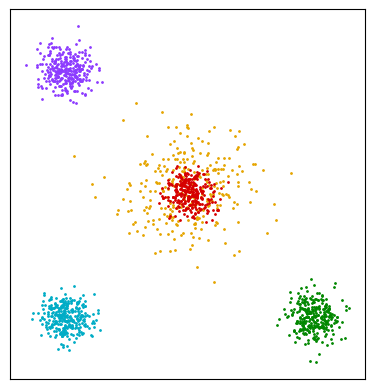

In [5]:
plot(case3())

### Confusion 4

- Case: 5 groups of various sizes, small group intermixed with larger
- Expected: smaller group should be confused with larger mixed group

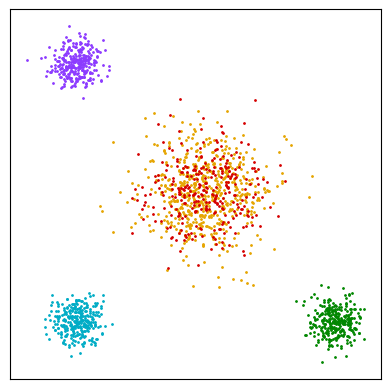

In [6]:
plot(case4())

### Confusion 5

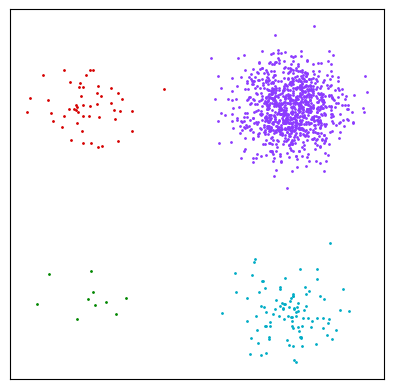

In [7]:
plot(case5())

## Testing


In [8]:
import functools

import pandas as pd
from sklearn.neighbors import NearestNeighbors

from embcomp.metrics import count_neighbor_labels


def run(metrics):
    for case in [case1, case2, case3, case4, case5]:
        plot_confusion(case(), metrics)

#### Fixed _k_

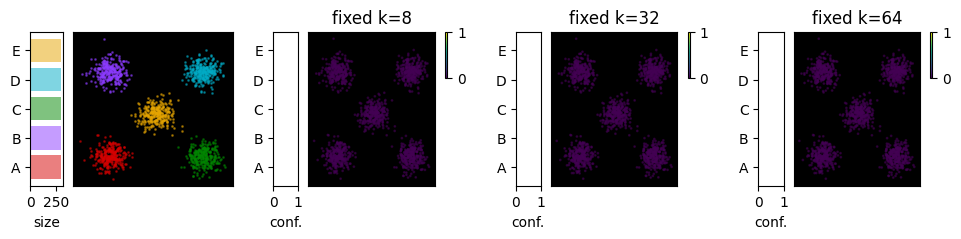

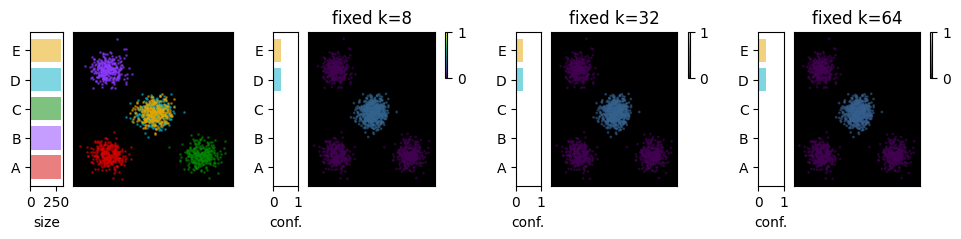

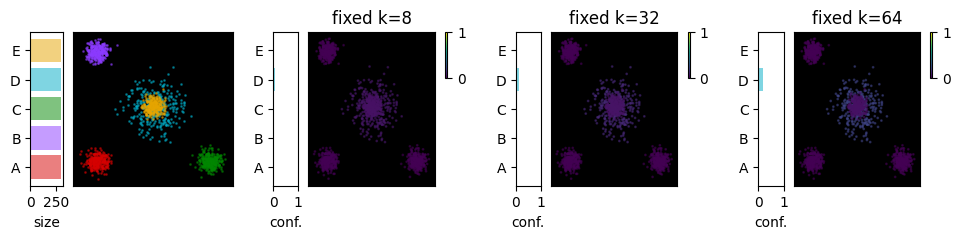

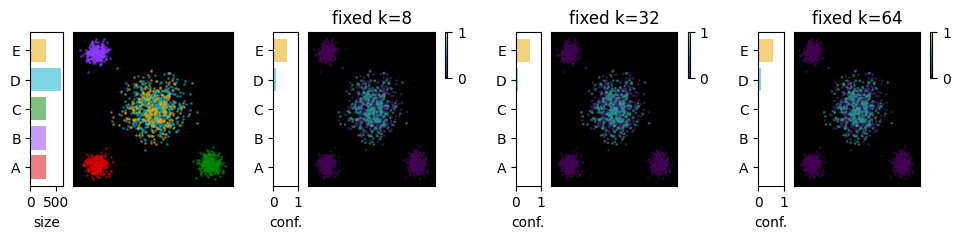

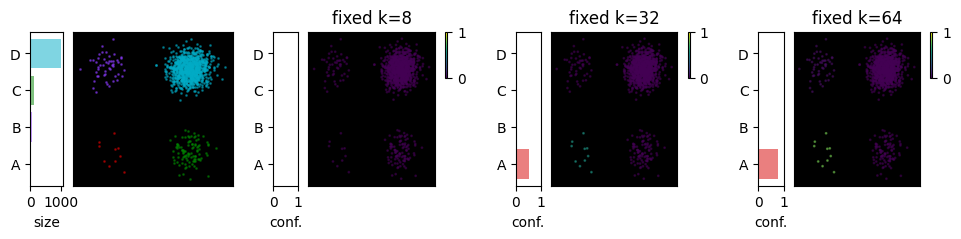

In [9]:
def fixed_k(data: pd.DataFrame, k):
    nn = NearestNeighbors(n_neighbors=k).fit(data[["x", "y"]])
    knn_indices = nn.kneighbors(return_distance=False)
    counts = count_neighbor_labels(knn_indices, data.label)
    index = pd.Series(data.label, name="label", dtype="category")
    df = pd.DataFrame(counts, index=index).groupby("label").sum()
    df.columns = index.cat.categories
    return df


run([
    ("fixed k=8", functools.partial(fixed_k, k=8)),
    ("fixed k=32", functools.partial(fixed_k, k=32)),
    ("fixed k=64", functools.partial(fixed_k, k=64)),
])